### 1.1 Mount Google Drive

In [ ]:
# Mount Google Drive to Access Data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 1.2 Install PySpark

In [ ]:
!pip install --upgrade --quiet pyspark
!pip install --upgrade --quiet PyDrive
!apt install openjdk-8-jdk-headless -qqq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"



E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


### 1.3 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import pyspark as spark
import matplotlib.pyplot as plt
from pyspark.ml.fpm import FPGrowth

from pyspark.sql import SparkSession
from pyspark.sql.functions import when

# Start a SparkSession
spark = SparkSession \
  .builder \
  .appName("Python Spark SQL basic example") \
  .config("spark.some.config.option", "some-value") \
  .getOrCreate()

### 1.4 Import Bridge Inventory & Supporting Information

In [ ]:
# Read in the bridge inventory via csv file
nbi = spark.read.csv("./drive/MyDrive/data/2022AllRecordsDelimitedAllStates.txt", \
                    header=True)

# Display the inventory data and size
nbi.show(5)
print((nbi.count(), len(nbi.columns)))

+--------------+--------------------+----------------+-----------------+------------------+-----------------+--------------+--------------------+---------------+--------------+--------------------+----------------------+--------------------+--------------------+----------------+-------------+--------------------+------------------+----------------+--------+---------+----------------+--------+---------------+---------+--------------------+--------------+---------------------+----------------------+-------+------------+---------------+-----------------+---------------+----------------+--------------------+-------------+----------------+--------------+------------------+-----------+--------------+-------------------+-------------------+----------------------+---------------+----------------+-------------------+-------------------+--------------+--------------+-------------------+--------------+---------------+-------------------+--------------------+-----------------+------------------+--

In [ ]:
# Read in attribute tables table
bridge_types = spark.read.csv('./drive/MyDrive/data/bridge_types.csv', header=True)
bridge_types.createOrReplaceTempView('bridge_types')

materials = spark.read.csv('./drive/MyDrive/data/material.csv', header=True)
materials.createOrReplaceTempView('materials')

ratings = spark.read.csv('./drive/MyDrive/data/ratings.csv', header=True)
ratings.createOrReplaceTempView('ratings')

low_rating = spark.read.csv('./drive/MyDrive/data/low_rating.csv', header=True)
low_rating.createOrReplaceTempView('low_rating')

super_rating = spark.read.csv('./drive/MyDrive/data/super_rating.csv', header=True)
super_rating.createOrReplaceTempView('super_rating')

sub_rating = spark.read.csv('./drive/MyDrive/data/sub_rating.csv', header=True)
sub_rating.createOrReplaceTempView('sub_rating')

deck_rating = spark.read.csv('./drive/MyDrive/data/deck_rating.csv', header=True)
deck_rating.createOrReplaceTempView('deck_rating')

deck_types = spark.read.csv('./drive/MyDrive/data/deck_types.csv', header=True)
deck_types.createOrReplaceTempView('deck_types')

states = spark.read.csv('./drive/MyDrive/data/states.csv', header=True)
states.createOrReplaceTempView('states')

## 2.0 Explore the Dataset

### 2.1 Remove Unwanted Columns of Data

In [ ]:
# Save attribute names to a single variable
column_names = nbi.columns

# Create a list of data columns to keep
keep_columns = ['STATE_CODE_001', 'STRUCTURE_NUMBER_008', 'YEAR_BUILT_027', 'ADT_029', \
                'MAIN_UNIT_SPANS_045', 'APPR_SPANS_046',  'DECK_COND_058', \
                'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060', 'STRUCTURE_KIND_043A', \
                'STRUCTURE_TYPE_043B', 'DECK_STRUCTURE_TYPE_107', 'LOWEST_RATING']

# Create an empty list to store column names to drop
drop_columns = []

# Loop over column names and append column numbers to the drop list that aren't in keep_columns
i=0
for name in column_names:
    if name not in keep_columns:
        drop_columns.append(name)
    i += 1

# Drop unwanted columns
nbi = nbi.drop(*drop_columns)

nbi.show(5)

# Replace view of inventory for future use
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

+--------------+--------------------+--------------+-------+-------------------+-------------------+-------------------+--------------+-------------+-----------------------+---------------------+-----------------------+-------------+
|STATE_CODE_001|STRUCTURE_NUMBER_008|YEAR_BUILT_027|ADT_029|STRUCTURE_KIND_043A|STRUCTURE_TYPE_043B|MAIN_UNIT_SPANS_045|APPR_SPANS_046|DECK_COND_058|SUPERSTRUCTURE_COND_059|SUBSTRUCTURE_COND_060|DECK_STRUCTURE_TYPE_107|LOWEST_RATING|
+--------------+--------------------+--------------+-------+-------------------+-------------------+-------------------+--------------+-------------+-----------------------+---------------------+-----------------------+-------------+
|            01|     00000000000S702|          1999|     50|                  5|                 05|                  1|             0|            7|                      5|                    7|                      2|            5|
|            01|     00000000000S703|          2002|    159|    

### 2.2 Visualize Distribution of Bridge Types

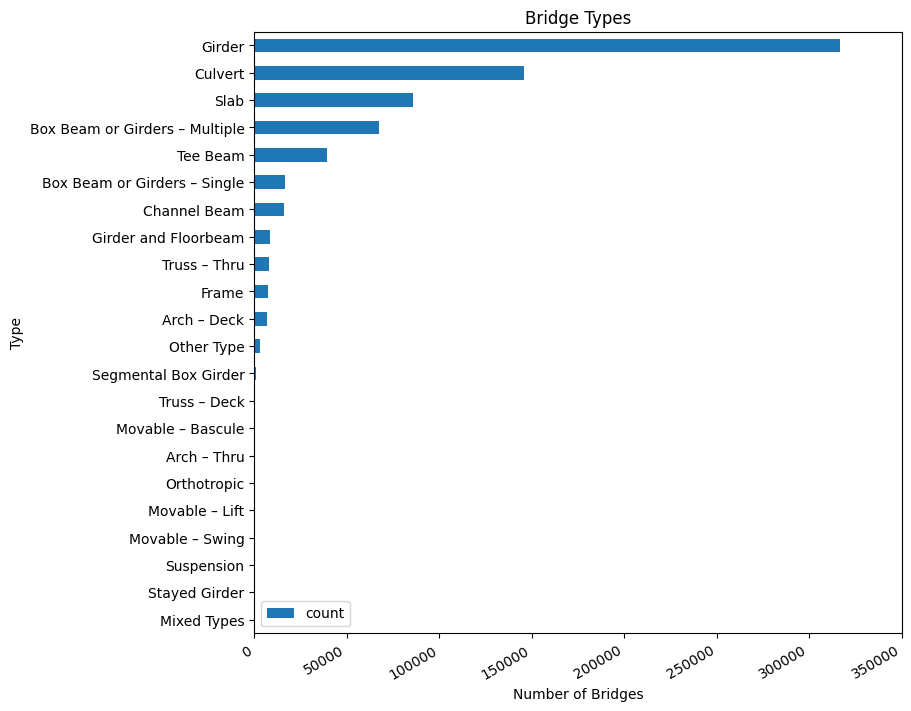

In [ ]:
# Create a dataframe with the total number of each structure type
struct_type = spark.sql('SELECT STRUCTURE_TYPE_043B, COUNT(STRUCTURE_TYPE_043B) as count FROM nbi GROUP BY STRUCTURE_TYPE_043B ORDER BY count DESC')
struct_type.createOrReplaceTempView('struct_type')

# Perform and SQL inner join to replace the structure type code with the actual bridge type
struct_type = spark.sql("SELECT BRIDGE_TYPE, count \
                          FROM struct_type \
                          INNER JOIN bridge_types \
                          ON struct_type.STRUCTURE_TYPE_043B = bridge_types.code \
                          ORDER BY count DESC")

# Replace view of structure_type dataframe for future use
struct_type.createOrReplaceTempView('struct_type')

# Convert struct_type to a Pandas dataframe for ease of plotting
struct_type = struct_type.toPandas()
struct_type = struct_type.set_index('BRIDGE_TYPE')

# Create a bar plot of bridge types
fig, ax = plt.subplots(figsize=(9, 7), layout='constrained')
myplot = struct_type.sort_values('count').plot(ax=ax, kind='barh')

# Customize the chart
plt.title("Bridge Types")
plt.xlabel("Number of Bridges")
plt.xlim(0,350000)
plt.ylabel("Type")
plt.xticks(rotation=30, horizontalalignment='right');

### Drop culverts to focus on traditional span bridges.

In [ ]:
# Drop culverts from inventory
nbi = nbi.filter(nbi.STRUCTURE_TYPE_043B != 19)
nbi.createOrReplaceTempView('nbi')

### 2.3 Visualize Distribution of Bridge Ratings

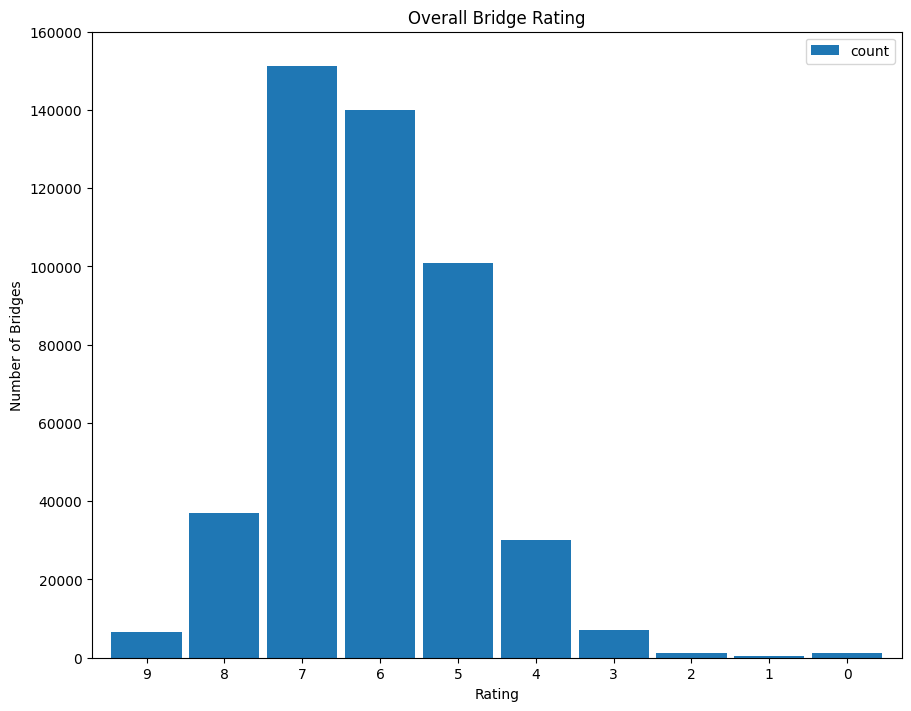

In [ ]:
bridge_ratings = spark.sql('SELECT LOWEST_RATING, COUNT(LOWEST_RATING) as count FROM nbi GROUP BY LOWEST_RATING ORDER BY LOWEST_RATING DESC')
bridge_ratings.createOrReplaceTempView('bridge_ratings')

# Filter out null values and 'Not Applicable' bridge ratings
bridge_ratings = bridge_ratings.filter(bridge_ratings.LOWEST_RATING != 'N')

# Convert struct_type to a Pandas dataframe for ease of plotting
bridge_ratings = bridge_ratings.toPandas()
bridge_ratings = bridge_ratings.set_index('LOWEST_RATING')

# Create a bar plot of bridge ratings
fig, ax = plt.subplots(figsize=(9, 7), layout='constrained')
my_plot = bridge_ratings.plot(ax=ax, kind='bar', width=0.9)

# Customize the chart
plt.title("Overall Bridge Rating")
plt.xlabel("Rating")
plt.ylim(0,160000)
plt.ylabel("Number of Bridges")
plt.xticks(rotation=0, horizontalalignment='center');

In [ ]:
ratings.show()

+---+----------------+
| id|BRIDGE_CONDITION|
+---+----------------+
|  N|  Not Applicable|
|  9|       Excellent|
|  8|       Very Good|
|  7|            Good|
|  6|    Satisfactory|
|  5|            Fair|
|  4|            Poor|
|  3|         Serious|
|  2|        Critical|
|  1|Imminent Failure|
|  0|          Failed|
+---+----------------+



### 2.4 Visualize Age Distribution of Bridges

In [ ]:
# Create a new column for bridge age and calculate age
nbi = nbi.withColumn('BRIDGE_AGE', 2023-nbi.YEAR_BUILT_027)
nbi.createOrReplaceTempView('nbi')

# Copy bridge age data into a new dataframe and convert it to pandas
# for ease of plotting
bridge_age_df = nbi.select('BRIDGE_AGE')
bridge_age_df = bridge_age_df.toPandas()

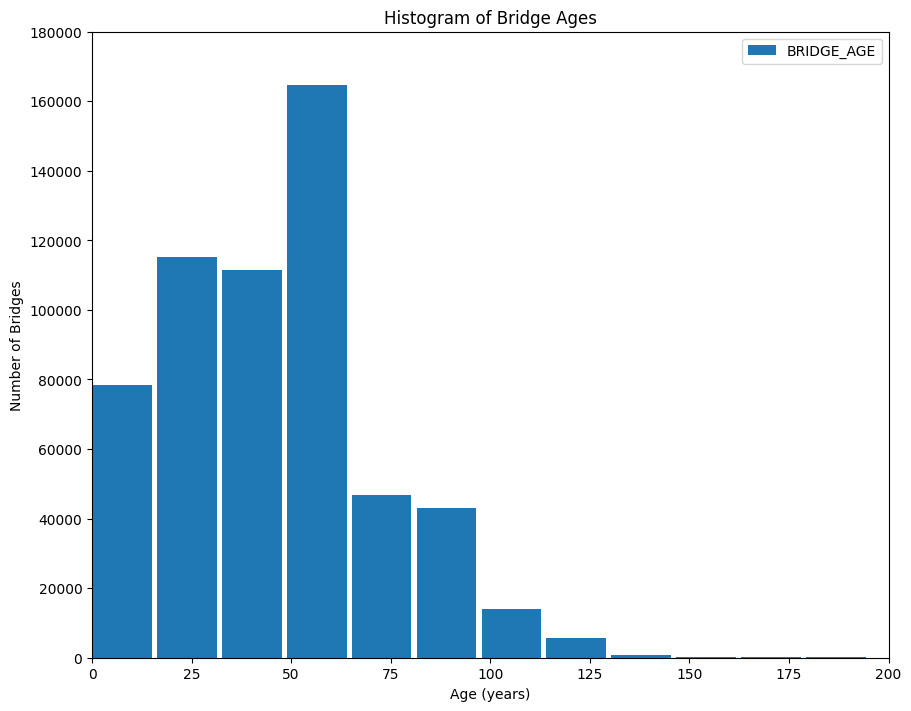

In [ ]:
# Create a figure and histogram of bridge ages
fig, ax = plt.subplots(figsize=(9, 7), layout='constrained')
my_plot = bridge_age_df.plot(ax=ax, kind='hist', width=15, bins=20)

# Customize the chart
plt.title("Histogram of Bridge Ages")
plt.xlabel("Age (years)")
plt.xlim(0,200)
plt.ylim(0,180000)
plt.ylabel("Number of Bridges")
plt.xticks(rotation=0, horizontalalignment='center');

### 2.5 Visualize Distribution of Total Number of Spans

In [ ]:
# Create a new column for tota number of spans & calculate data to fill it
nbi = nbi.withColumn('TOTAL_SPANS', nbi.MAIN_UNIT_SPANS_045 + nbi.APPR_SPANS_046)
nbi.createOrReplaceTempView('nbi')

# Remove bridges with 0 spans
nbi = nbi.filter(nbi.TOTAL_SPANS > 0)
nbi.createOrReplaceTempView('nbi')

# Split bridge ages into groups
nbi = nbi.withColumn("SPAN_GROUPS", \
   when((nbi.TOTAL_SPANS <= 2), "01-02 Spans") \
     .when((nbi.TOTAL_SPANS > 2) & (nbi.TOTAL_SPANS <= 4), "03-04 Spans") \
     .when((nbi.TOTAL_SPANS > 4) & (nbi.TOTAL_SPANS <= 6), "05-06 Spans") \
     .when((nbi.TOTAL_SPANS > 6) & (nbi.TOTAL_SPANS <= 8), "07-08 Spans") \
     .when((nbi.TOTAL_SPANS > 8) & (nbi.TOTAL_SPANS <= 10), "09-10 Spans") \
     .otherwise("11 Plus Spans") \
  )
nbi.createOrReplaceTempView('nbi')
print((nbi.count(), len(nbi.columns)))

(475601, 16)


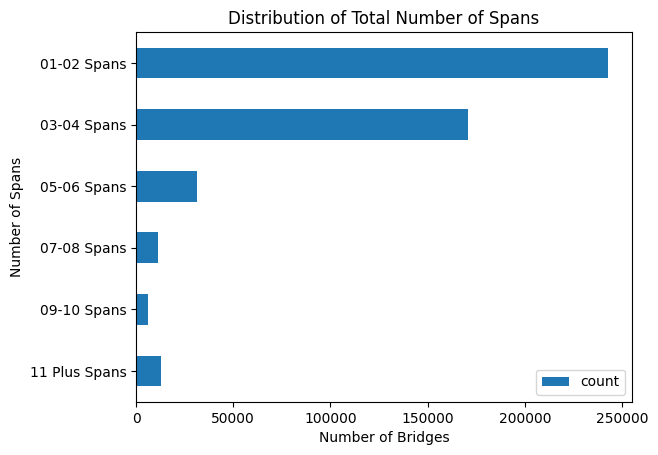

In [ ]:
# Create a table of SPAN_GROUPS and the number of bridges in each group
span_data = nbi.groupBy('SPAN_GROUPS').count()
span_data = span_data.toPandas()
span_data = span_data.set_index('SPAN_GROUPS')
span_data = span_data.sort_index(ascending=False)

# Create histogram of total spans
span_data.plot.barh();

# Customize the chart
plt.title("Distribution of Total Number of Spans")
plt.ylabel("Number of Spans")
plt.xlim(0,)
plt.xlabel("Number of Bridges")
plt.xticks(rotation=0, horizontalalignment='center');

## 3. Prepare Data for FPGrowth Algorithm

In [ ]:
#Refresh nbi view
nbi.createOrReplaceTempView('nbi')

In [ ]:
# Split bridge ages into groups
nbi = nbi.withColumn("AGE_GROUP", \
   when((nbi.BRIDGE_AGE <= 25), "0-25 Years Old") \
     .when((nbi.BRIDGE_AGE > 25) & (nbi.BRIDGE_AGE <= 50), "26-50 Years Old") \
     .when((nbi.BRIDGE_AGE > 50) & (nbi.BRIDGE_AGE <= 75), "51-75 Years Old") \
     .when((nbi.BRIDGE_AGE > 75) & (nbi.BRIDGE_AGE <= 100), "76-100 Years Old") \
     .otherwise("Over 100 Years Old") \
  )
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

In [ ]:
# Create a column for Lowest Bridge Condition & use an SQL inner join on Structure Type
nbi = spark.sql("SELECT nbi.*, BRIDGE_CONDITION \
                    FROM nbi \
                    INNER JOIN low_rating \
                    ON nbi.LOWEST_RATING = low_rating.id")
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

In [ ]:
# Create a column for Deck Condition & use an SQL inner join on Structure Type
nbi = spark.sql("SELECT nbi.*, DECK_CONDITION \
                    FROM nbi \
                    INNER JOIN deck_rating \
                    ON nbi.DECK_COND_058 = deck_rating.id")
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

In [ ]:
# Create a column for Superstructure Condition & use an SQL inner join on Structure Type
nbi = spark.sql("SELECT nbi.*, SUPER_CONDITION \
                    FROM nbi \
                    INNER JOIN super_rating \
                    ON nbi.SUPERSTRUCTURE_COND_059 = super_rating.id")
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

In [ ]:
# Create a column for Substructure Condition & use an SQL inner join on Structure Type
nbi = spark.sql("SELECT nbi.*, SUBSTRUCTURE_CONDITION \
                    FROM nbi \
                    INNER JOIN sub_rating \
                    ON nbi.SUBSTRUCTURE_COND_060 = sub_rating.id")
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

In [ ]:
# Create a column for bridge type using an SQL inner join on type code
nbi = spark.sql("SELECT nbi.*, BRIDGE_TYPE \
                    FROM nbi \
                    INNER JOIN bridge_types \
                    ON nbi.STRUCTURE_TYPE_043B = bridge_types.code")
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

In [ ]:
# Create a column for deck type using an SQL inner join on type code
nbi = spark.sql("SELECT nbi.*, DECK_TYPE \
                    FROM nbi \
                    INNER JOIN deck_types \
                    ON nbi.DECK_STRUCTURE_TYPE_107 = deck_types.code")
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

In [ ]:
# Create a column with the bridge regions
nbi = spark.sql("SELECT nbi.*, REGION \
                    FROM nbi \
                    INNER JOIN states \
                    ON nbi.STATE_CODE_001 = states.ID")
nbi.createOrReplaceTempView('nbi')
print((nbi.count(), len(nbi.columns)))

(418179, 24)


In [ ]:
# Split bridges into groups of varying Average Daily Traffic (ADT)
nbi = nbi.withColumn("ADT_GROUP", \
   when((nbi.ADT_029 <= 25000), "0 - 25k ADT") \
     .when((nbi.ADT_029 > 25000) & (nbi.ADT_029 <= 50000), "25k - 50k ADT") \
     .when((nbi.ADT_029 > 50000) & (nbi.ADT_029 <= 75000), "50k - 75k ADT") \
     .when((nbi.ADT_029 > 75000) & (nbi.ADT_029 <= 100000), "75k - 100k ADT") \
     .otherwise("Over 100k ADT") \
  )
nbi.createOrReplaceTempView('nbi')
#print((nbi.count(), len(nbi.columns)))

In [ ]:
# Create a column with bridge material
nbi = spark.sql("SELECT nbi.*, BR_MATERIAL \
                    FROM nbi \
                    INNER JOIN materials \
                    ON nbi.STRUCTURE_KIND_043A = materials.CODE")
nbi.createOrReplaceTempView('nbi')

nbi=nbi.filter(nbi.LOWEST_RATING != 'N')
nbi=nbi.filter(nbi.DECK_COND_058 != 'N')
nbi=nbi.filter(nbi.SUPERSTRUCTURE_COND_059 != 'N')
nbi=nbi.filter(nbi.SUBSTRUCTURE_COND_060 != 'N')
nbi.createOrReplaceTempView('nbi')

nbi.show(10)
print((nbi.count(), len(nbi.columns)))

+--------------+--------------------+--------------+-------+-------------------+-------------------+-------------------+--------------+-------------+-----------------------+---------------------+-----------------------+-------------+----------+-----------+-----------+------------------+----------------+--------------+---------------+----------------------+--------------------+-------------------+---------+-----------+-----------------+
|STATE_CODE_001|STRUCTURE_NUMBER_008|YEAR_BUILT_027|ADT_029|STRUCTURE_KIND_043A|STRUCTURE_TYPE_043B|MAIN_UNIT_SPANS_045|APPR_SPANS_046|DECK_COND_058|SUPERSTRUCTURE_COND_059|SUBSTRUCTURE_COND_060|DECK_STRUCTURE_TYPE_107|LOWEST_RATING|BRIDGE_AGE|TOTAL_SPANS|SPAN_GROUPS|         AGE_GROUP|BRIDGE_CONDITION|DECK_CONDITION|SUPER_CONDITION|SUBSTRUCTURE_CONDITION|         BRIDGE_TYPE|          DECK_TYPE|   REGION|  ADT_GROUP|      BR_MATERIAL|
+--------------+--------------------+--------------+-------+-------------------+-------------------+-------------------+

## 4.0 Run FPGrowth on Full Dataset & Report Association Rules

In [ ]:
# Convert inventory to rdd with a lambda function that
# 1. retains structure number as it's own column for record keeping
# 2. combines the age group, material, structure type, state, and bridge condition
#    into a list for each record
nbi_rdd = nbi.rdd.map(lambda x:
                      (x[1],[x[15],x[16],x[18],x[19],x[20],x[21],x[22],\
                             x[23],x[25]])
                     )

# Convert rdd back into a dataframe
nbi2 = nbi_rdd.toDF(['STRUCTURE_NUMBER_008', 'ATTRIBUTES'])

In [ ]:
# Create & Run FPGrowth Model
fpGrowth = FPGrowth(itemsCol="ATTRIBUTES", minSupport=0.25, minConfidence=0.40)
model = fpGrowth.fit(nbi2)

# Store generated association rules.
rules = model.associationRules
rules.count()

125

In [ ]:
rules.show(50,False)

+----------------------------------------------------+-------------------+-------------------+------------------+-------------------+
|antecedent                                          |consequent         |confidence         |lift              |support            |
+----------------------------------------------------+-------------------+-------------------+------------------+-------------------+
|[Girder, Good Sub]                                  |[Good Super]       |0.8325510959030796 |1.137617376381001 |0.34843969229280564|
|[Girder, Good Sub]                                  |[Good Deck]        |0.9025420789790067 |1.1254448461370101|0.37773235279887757|
|[Girder, Good Sub]                                  |[Concrete CIP Deck]|0.8061997133080551 |1.136122744445071 |0.33741109874691566|
|[Girder, Concrete CIP Deck, Good Super, Good Deck]  |[Good Sub]         |0.9323500055450815 |1.2200494626234986|0.264383859886787  |
|[Good Deck]                                         |[Concret

### Write output to CSV file

In [ ]:
# Convert antecedent & consequent from array to text string
rule_output = rules.withColumn("antecedent",  rules["antecedent"]
                                  .cast('string'))
rule_output = rule_output.withColumn("consequent",  rule_output["consequent"]
                                  .cast('string'))

# Coalesce rules into a single file
rule_output = rule_output.coalesce(1)

# Write rules to csv in the data folder
rule_output.write.mode('overwrite').csv("./drive/MyDrive/output/rules1")

In [ ]:
# Store frequent itemsets.
items = model.freqItemsets

item_output = items.withColumn("items",  items["items"]
                                  .cast('string'))

# Coalesce items into a single file
item_output = item_output.coalesce(1)

# Write rules to csv in the data folder
item_output.write.mode('overwrite').csv("./drive/MyDrive/output/items1")

## 4.1 Re-Run FPGrowth on Bridges With Poor Condition or Worse & Report Association Rules

In [ ]:
nbi_low = nbi.filter(nbi.LOWEST_RATING < 5)
nbi_low.show(5)
print('Number of deficient bridges: ', nbi_low.count())

+--------------+--------------------+--------------+-------+-------------------+-------------------+-------------------+--------------+-------------+-----------------------+---------------------+-----------------------+-------------+----------+-----------+-----------+------------------+----------------+--------------+---------------+----------------------+--------------------+-------------------+---------+-----------+----------------+
|STATE_CODE_001|STRUCTURE_NUMBER_008|YEAR_BUILT_027|ADT_029|STRUCTURE_KIND_043A|STRUCTURE_TYPE_043B|MAIN_UNIT_SPANS_045|APPR_SPANS_046|DECK_COND_058|SUPERSTRUCTURE_COND_059|SUBSTRUCTURE_COND_060|DECK_STRUCTURE_TYPE_107|LOWEST_RATING|BRIDGE_AGE|TOTAL_SPANS|SPAN_GROUPS|         AGE_GROUP|BRIDGE_CONDITION|DECK_CONDITION|SUPER_CONDITION|SUBSTRUCTURE_CONDITION|         BRIDGE_TYPE|          DECK_TYPE|   REGION|  ADT_GROUP|     BR_MATERIAL|
+--------------+--------------------+--------------+-------+-------------------+-------------------+-------------------+--

In [ ]:
# Convert inventory to rdd with a lambda function that
# 1. retains structure number as it's own column for record keeping
# 2. combines the age group, material, structure type, state, and bridge condition
#    into a list for each record
nbi_rdd = nbi_low.rdd.map(lambda x:
                      (x[1],[x[15],x[16],x[18],x[19],x[20],x[21],x[22],\
                             x[23],x[25]])
                      )

# Convert rdd back into a dataframe
nbi2 = nbi_rdd.toDF(['STRUCTURE_NUMBER_008', 'ATTRIBUTES'])

In [ ]:
# Run FPGrowth algorithm and generate association rules
fpGrowth = FPGrowth(itemsCol="ATTRIBUTES", minSupport=0.15, minConfidence=0.20)
model = fpGrowth.fit(nbi2)

# Store generated association rules.
rules = model.associationRules
rules.count()

361

In [ ]:
rules.show(50,False)

+-----------------------------------------+-------------------+-------------------+------------------+-------------------+
|antecedent                               |consequent         |confidence         |lift              |support            |
+-----------------------------------------+-------------------+-------------------+------------------+-------------------+
|[Good Super, Concrete CIP Deck, Poor Sub]|[Good Deck]        |0.8688728883965661 |1.4734553410389446|0.17600201946540264|
|[51-75 Years Old, Good Super, Good Deck] |[Poor Sub]         |1.0                |1.6988135512460094|0.1543488626483045 |
|[Mid-West, Good Super, Good Deck]        |[Poor Sub]         |1.0                |1.6988135512460094|0.17880683252461224|
|[Good Deck]                              |[51-75 Years Old]  |0.4155726788432268 |0.997805422506402 |0.24505651698314307|
|[Good Deck]                              |[Concrete CIP Deck]|0.5110825722983258 |0.930196893672582 |0.3013771632120719 |
|[Good Deck]    

### Write output to CSV file

In [ ]:
# Convert antecedent & consequent from array to text string
rule_output = rules.withColumn("antecedent",  rules["antecedent"]
                                  .cast('string'))
rule_output = rule_output.withColumn("consequent",  rule_output["consequent"]
                                  .cast('string'))

# Coalesce rules into a single file
rule_output = rule_output.coalesce(1)

# Write rules to csv in the data folder
rule_output.write.mode('overwrite').csv("./drive/MyDrive/output/rules2")

In [ ]:
# Store frequent itemsets.
items = model.freqItemsets

item_output = items.withColumn("items",  items["items"]
                                  .cast('string'))

# Coalesce items into a single file
item_output = item_output.coalesce(1)

# Write rules to csv in the data folder
item_output.write.mode('overwrite').csv("./drive/MyDrive/output/items2")